In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/railway-track-fault-detection-resized-224-x-224/rails.csv
/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid/Defective/IMG_20201211_121249.jpg
/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid/Defective/IMG_20201211_121703.jpg
/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid/Defective/IMG_20201211_121541.jpg
/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid/Defective/IMG_20201114_102932.jpg
/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid/Defective/IMG_20201114_102159.jpg
/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid/Defective/IMG_20201211_121524.jpg
/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid/Defective/IMG_20201211_121655.jpg
/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid/Defective/IMG_20201211_121327.jpg
/kaggle/input/railway-track-fault-detection-resized-224-x-224/valid/Defective/IMG_20201114_102417.jpg
/kaggle/in

## Importing Necessary Libraries and Packages

In [1]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Conv2D, Dropout, Dense, MaxPool2D,BatchNormalization,Flatten
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16 

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Glimpse of **CSV `DataFrame.`**

In [12]:
df = pd.read_csv("../input/railway-track-fault-detection-resized-224-x-224/rails.csv")

In [13]:
# CHECKING THE HEAD OF THE DATAFRAME
df.head()

,class index,filepaths,labels,data set
0,0,train/Defective/131004959_171473721383413_8222...,Defective,train
1,0,train/Defective/131051004_382613492830631_1306...,Defective,train
2,0,train/Defective/131065180_999185033824671_7735...,Defective,train
3,0,train/Defective/131084537_190751489449739_2798...,Defective,train
4,0,train/Defective/131092897_149705809860659_8798...,Defective,train


In [14]:
# CHECKING FOR ANY "NAN" VALUES IN THE DATA
df.isnull().sum()

class index    0
filepaths      0
labels         0
data set       0
dtype: int64

<AxesSubplot:ylabel='labels'>

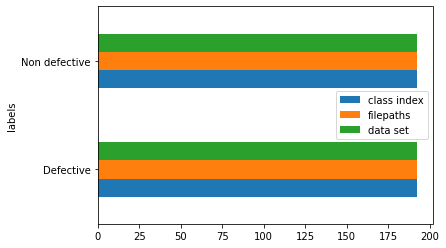

In [15]:
df.groupby('labels').count().plot.barh()

### Creating Plots to get better understanding of data

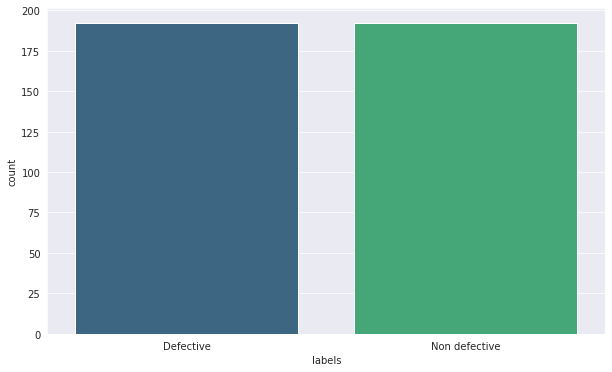

In [16]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.countplot(df['labels'],palette='viridis');
plt.savefig('Labels Count Total.svg')

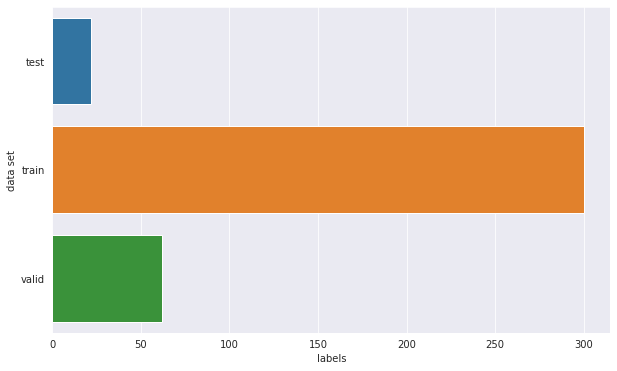

In [17]:
plt.figure(figsize=(10,6))
df_gb = df.groupby(by='data set').count()
df_gb.reset_index(inplace=True)
sns.barplot( df_gb['labels'],df_gb['data set'])
plt.savefig('Labels Count (In Each Data).svg')

### Grasping the **Labels** 

In [18]:
paths = glob.glob("../input/railway-track-fault-detection-resized-224-x-224/train/*")
l = len("../input/railway-track-fault-detection-resized-224-x-224/train/")
labels = []
for path in paths:
    labels.append(path[l:])
    
print(labels)

['Defective', 'Non defective']


### Creating a function for **`Dataset Preparation.`**

In [19]:
def dataset_preparation(path,label):
    x_train = []
    y_train = []
    path_img = glob.glob(path+'/*.jpg')
    for path in path_img:
        img = load_img(path,target_size=(150,150))
        img = img_to_array(img)
        img = img/255.0
        x_train.append(img)
        y_train.append(label)
        
    return x_train, y_train

### Plotting some Images from the Training Data

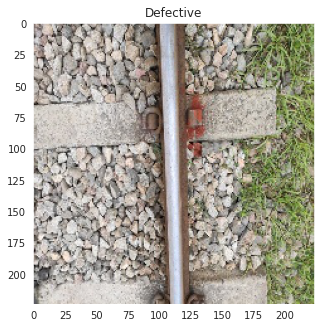

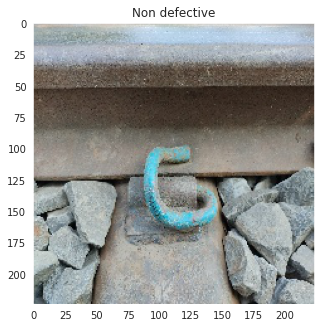

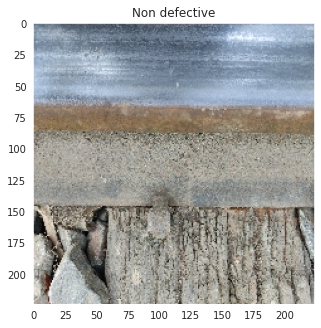

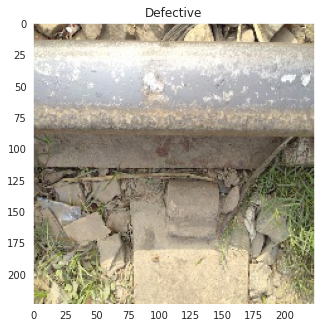

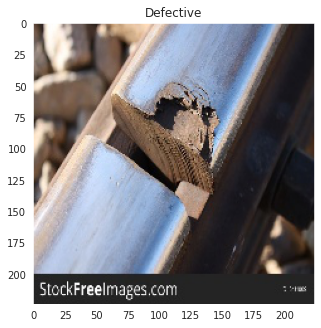

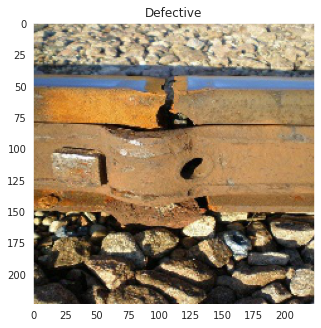

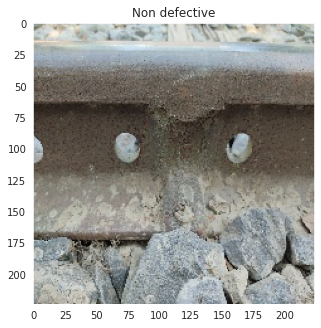

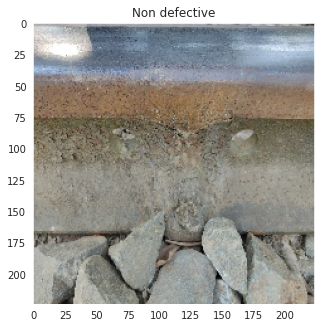

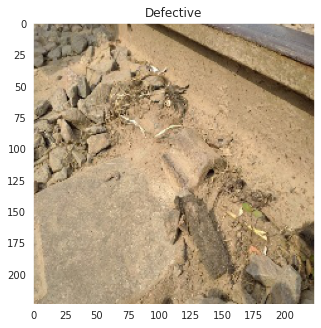

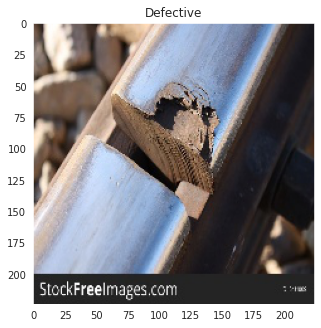

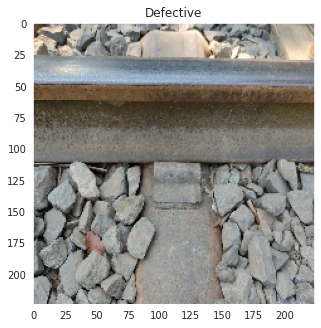

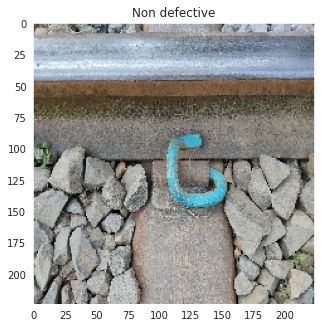

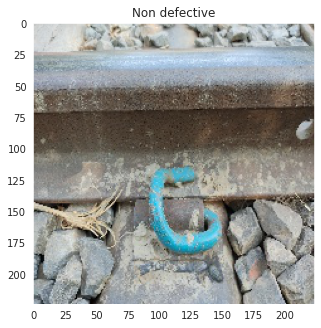

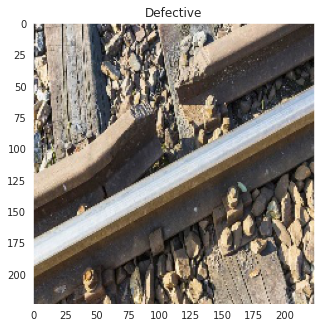

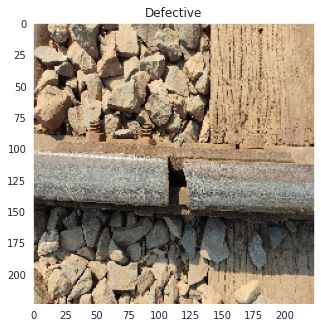

In [97]:
fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,1)
img1 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Defective/131004959_171473721383413_8222187747086021011_n.jpg")
img_plot = plt.imshow(img1)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,2)
img2 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Non defective/IMG_20201114_100021.jpg")
img_plot = plt.imshow(img2)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,3)
img3 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Non defective/IMG_20201114_100110.jpg")
img_plot = plt.imshow(img3)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,4)
img4 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Defective/131084537_190751489449739_279862595635733772_n.jpg")
img_plot = plt.imshow(img4)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,5)
img5 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Defective/6411009.jpg")
img_plot = plt.imshow(img5)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,6)
img1 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Defective/2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl (1).jpg")
img_plot = plt.imshow(img1)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,7)
img2 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Non defective/IMG_20201114_100134.jpg")
img_plot = plt.imshow(img2)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,8)
img3 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Non defective/IMG_20201114_100139.jpg")
img_plot = plt.imshow(img3)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,9)
img4 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Defective/131275810_2686956714949012_5021348409242545922_n.jpg")
img_plot = plt.imshow(img4)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,10)
img5 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Defective/6411009.jpg")
img_plot = plt.imshow(img5)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,11)
img1 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Defective/IMG_20201114_100226.jpg")
img_plot = plt.imshow(img1)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,12)
img2 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Non defective/IMG_20201114_100242.jpg")
img_plot = plt.imshow(img2)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,13)
img3 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Non defective/IMG_20201114_100052.jpg")
img_plot = plt.imshow(img3)
ax.set_title(labels[1])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,14)
img4 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Defective/Broken_railroad_tracks_1.jpg")
img_plot = plt.imshow(img4)
ax.set_title(labels[0])
plt.grid(visible=False)

fig = plt.figure(figsize=(20,30))
ax = fig.add_subplot(5,3,15)
img5 = load_img("../input/railway-track-fault-detection-resized-224-x-224/train/Defective/IMG_20201114_101138.jpg")
img_plot = plt.imshow(img5)
ax.set_title(labels[0])
plt.grid(visible=False)
plt.savefig('Images from Dataset.svg')

### **Preparation** of Dataset

In [11]:
defct_train_data = dataset_preparation(path="../input/railway-track-fault-detection-resized-224-x-224/train/Defective",label=labels[0])
ndefct_train_data = dataset_preparation(path="../input/railway-track-fault-detection-resized-224-x-224/train/Non defective",label=labels[1])

defct_test_data = dataset_preparation(path="../input/railway-track-fault-detection-resized-224-x-224/test/Defective",label=labels[0])
ndefct_test_data = dataset_preparation(path="../input/railway-track-fault-detection-resized-224-x-224/test/Non defective",label=labels[1])

defct_valid_data = dataset_preparation(path="../input/railway-track-fault-detection-resized-224-x-224/valid/Defective",label=labels[0])
ndefct_valid_data = dataset_preparation(path="../input/railway-track-fault-detection-resized-224-x-224/valid/Non defective",label=labels[1])

In [12]:
train_data = np.concatenate((defct_train_data,ndefct_train_data),axis=1)
test_data = np.concatenate((defct_test_data,ndefct_test_data),axis=1)
valid_data = np.concatenate((defct_valid_data,ndefct_valid_data),axis=1)

print(f"Shape of Training Data is {train_data.shape}.")
print(f"Shape of Testing Data is {test_data.shape}.")
print(f"Shape of Validation Data is {valid_data.shape}.")

Shape of Training Data is (2, 284).
Shape of Testing Data is (2, 22).
Shape of Validation Data is (2, 62).


### Making **Generators** for **Train**, **Test** and **Valid** Data

In [13]:
img_aug_tr = ImageDataGenerator(rescale=1.0/255)
train_gen = img_aug_tr.flow_from_directory("../input/railway-track-fault-detection-resized-224-x-224/train",
                                          target_size=(150,150),
                                          class_mode='categorical',
                                          batch_size=16)

Found 299 images belonging to 2 classes.


In [14]:
img_aug_tst = ImageDataGenerator(rescale=1.0/255)
test_gen = img_aug_tst.flow_from_directory("../input/railway-track-fault-detection-resized-224-x-224/test",
                                          target_size=(150,150),
                                          class_mode='categorical',
                                          batch_size=16)

Found 22 images belonging to 2 classes.


In [15]:
img_aug_vld = ImageDataGenerator(rescale=1.0/255)
valid_gen = img_aug_vld.flow_from_directory("../input/railway-track-fault-detection-resized-224-x-224/valid",
                                          target_size=(150,150),
                                          class_mode='categorical',
                                          batch_size=16)

Found 62 images belonging to 2 classes.


### Building our **CNN** Model

In [34]:
model = Sequential()

# PREPARING THE MODEL NETWORK

model.add(Conv2D(64,kernel_size=(3,3),activation='relu', input_shape=(150,150,3)))

# NORMALIZING THE LAYER
model.add(BatchNormalization())

# ADDING DROPOUT LAYER
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

# ADDING POOLING LAYER
model.add(MaxPool2D((2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(256,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

# FLATTENING CONVOLUTIONAL LAYER TO 1-D LAYER
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(16,activation='relu'))
model.add(Dropout(0.25))

# OUTPUT LAYER
model.add(Dense(2,activation='sigmoid'))

# MODEL SUMMARY
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 148, 148, 64)      256       
_________________________________________________________________
dropout_22 (Dropout)         (None, 148, 148, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 71, 71, 128)      

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='BinaryCrossentropy',
             metrics=['accuracy'])

In [36]:
# USING A CALLBACK FUNCTION TO STOP OVERFITTING
earlystop = EarlyStopping(monitor='val_loss',patience=30,verbose=1,mode='min')

model.fit_generator(train_gen,epochs=160,verbose=1,callbacks=[earlystop],
                   validation_data=(valid_gen))

Epoch 1/160
19/19 [==============================] - 2s 71ms/step - loss: 1.1223 - accuracy: 0.5151 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/160
19/19 [==============================] - 1s 58ms/step - loss: 0.9228 - accuracy: 0.4548 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/160
19/19 [==============================] - 1s 57ms/step - loss: 0.8033 - accuracy: 0.5084 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 4/160
19/19 [==============================] - 1s 56ms/step - loss: 0.7815 - accuracy: 0.5351 - val_loss: 0.6943 - val_accuracy: 0.5000
Epoch 5/160
19/19 [==============================] - 1s 55ms/step - loss: 0.7792 - accuracy: 0.4783 - val_loss: 0.6953 - val_accuracy: 0.5000
Epoch 6/160
19/19 [==============================] - 1s 56ms/step - loss: 0.7220 - accuracy: 0.5452 - val_loss: 0.6961 - val_accuracy: 0.5000
Epoch 7/160
19/19 [==============================] - 1s 57ms/step - loss: 0.7732 - accuracy: 0.4649 - val_loss: 0.6976 - val_accuracy: 0.5000
Epoch 

### Model **Evaluation**

In [37]:
model.evaluate(train_gen,batch_size=16,verbose=1,callbacks=[earlystop])

19/19 [==============================] - 1s 41ms/step - loss: 0.7010 - accuracy: 0.5017


[0.7010194659233093, 0.5016722679138184]

### Predicting our Model on **Test Data**

In [52]:
predictions = model.predict(test_gen,batch_size=8,verbose=1,callbacks=[earlystop])
predictions

2/2 [==============================] - 0s 16ms/step


array([[0.41574508, 0.5540232 ],
       [0.40689677, 0.5581344 ],
       [0.42390817, 0.5451823 ],
       [0.4116912 , 0.54842603],
       [0.39797676, 0.5542404 ],
       [0.40837416, 0.5552164 ],
       [0.41683364, 0.5446251 ],
       [0.40744895, 0.55366176],
       [0.4236067 , 0.55170757],
       [0.40947637, 0.5608825 ],
       [0.38834336, 0.57158524],
       [0.43927288, 0.53840995],
       [0.4315238 , 0.55487883],
       [0.4021207 , 0.55876267],
       [0.39053237, 0.56745243],
       [0.40833956, 0.55675364],
       [0.400608  , 0.5581731 ],
       [0.40733412, 0.54880387],
       [0.419072  , 0.542254  ],
       [0.40747723, 0.5473063 ],
       [0.3596147 , 0.5764572 ],
       [0.42906594, 0.5439459 ]], dtype=float32)

In [60]:
test_pred = pd.DataFrame(predictions,columns=['Test Loss','Test Accuracy'])
test_pred.head()

,Test Loss,Test Accuracy
0,0.415745,0.554023
1,0.406897,0.558134
2,0.423908,0.545182
3,0.411691,0.548426
4,0.397977,0.554240


### Data Analysis on Test Predictions

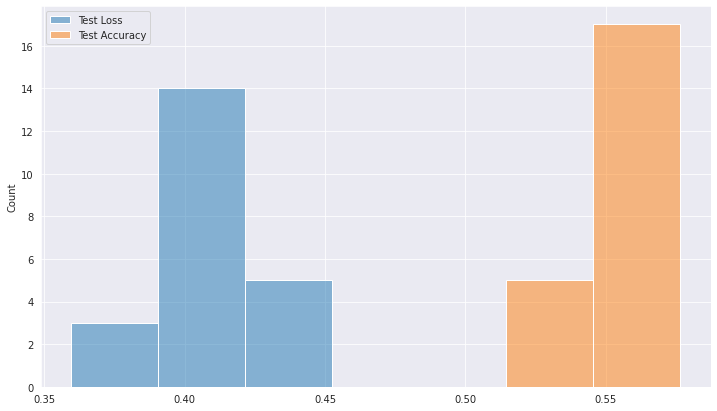

In [98]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)
sns.histplot(test_pred);
plt.savefig('Test Prediction Count.svg')

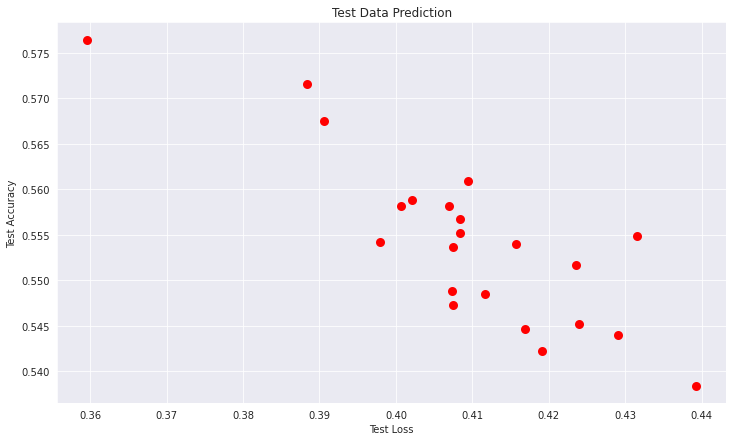

In [99]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)
ax.scatter(test_pred['Test Loss'],test_pred['Test Accuracy'],marker='o',c='red',cmap='viridis',linewidths=3);
ax.set_title("Test Data Prediction")
ax.set_xlabel(test_pred.columns[0])
ax.set_ylabel(test_pred.columns[1])
plt.savefig('Test Prediction Plot.svg')

### SAVING THE MODEL

In [87]:
model.save('railway_track_fault_detection.h5')